# Entrega 3
En esta última entrega realizaremos unos algoritmos un poco mas avanzados que podemos usar para hacer segmentación. Inicialmente usaremos el algoritmo de watersheds donde podremos hacer nosotros una primera aproximación y tener claridad de como usarlo. Mas adelante usaremos las semillas de dos formas diferentes: con h-minimos e imponiendo marcadores. Despues de usar watersheds vamos a hacer segmentación usando varias estrategías utilizando este proceso inicial.

## Parte 1: Watersheds
Inicialmente usaremos watersheds o la linea divisoria de aguas. Como saben este algoritmo es basado en una imagen de 2 dimensiones y no un volumen. Sin embargo, si trasladamos los principios que están en dos dimensiones y pensamos en nuestro volumen en 3 dimensiones donde las intensidades son porosidad, densidad o temperatura (que son las interpretaciones que para ustedes pueden resultar mas intuitivas) podemos hacer watersheds en 3 dimensiones.

### 1.1 Watersheds 
Inicalmente lo que haremos será dividir usando watersheds sin muchos problema, aqui obtendremos nuestras semillas de forma automatica. Lo que nos va a importar en esta primera parte es encontrar lo que serán nuestros bordes.

Si recordamos bien la forma mas facil de sacar los bordes es usando los filtros de bordes de sobel, sin embargo, estos estan pensados para ser usados en imagenes, no en volumen. Si bien podríamos, por ejemplo, filtrar cada corte, esto desaprovecharía la informacion adyasente en una de las dimensiones. Por esto, vamos a obtener la informacion de los bordes mediante el uso del gradiente morfologico. Este operador, está pensado originalment en 2 dimensiones pero puede ser usado facilmente en un volumen al cambiar nuestro elemento estructurante de ser 2D a ser 3D. Así podemos usar el mismo principio para tener en cuenta el gradiente en todas las direcciones.

Lo que primero vamos a hacer será justamente calcular este gradiente en 3D, notemos que si la funcion que realizamos del gradiente morfológico en el tutorial de la semana 7 la hicimos de forma correcta vamos a lograr tener ya una funcion que nos realice el gradiente morfológico incluso en 3D. Por esto usaremos la misma función, en caso que su función no sirva para hacer la operación en 3D.

In [1]:
import os
import numpy as np
from glob import glob
from tqdm import tqdm
import nibabel as nib
from skimage.measure import label
from matplotlib import pyplot as plt
from skimage.segmentation import watershed
from skimage.morphology import dilation, erosion, opening, closing, h_minima, ball, disk, cube

import warnings
try:
    import cupy as cp
except ImportError:
    warnings.warn("CuPy not found. Falling back to NumPy.")

C:\Users\john2\anaconda3\lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
borders = '' #Variable que tendrá los bordes del volumen 1 de entrenamiento 
element = '' #Variable que tendrá un elemento estructurante de esfera de radio 5

vol1 = nib.load(os.path.join('DB', 'train', 'volume_1.nii.gz')).get_fdata()
seg1=nib.load(os.path.join('DB', 'train', 'segmentation_1.nii.gz')).get_fdata()

element = ball(5) #Variable que tendrá un elemento estructurante de esfera de radio 5

def morph_gradient(gray_img,EE):
    result = "" #Variable que tendrá la imagen resultante
    dilated = dilation(gray_img, EE)
    eroded = erosion(gray_img, EE)
    result = dilated - eroded
    return result

borders = morph_gradient(vol1,element)

In [3]:
assert borders.shape == (512,512,123), f'Alteró el tamaño de su volumen, debe ser (512,512,123) no {borders.shape}'
assert len(element.shape)==3,f'su elemento estructurante debería tener 3 dimensiones, no {len(element.shape)}'
assert element.shape==(11,11,11),f'su elemento estructurante está definido erroneamente su tamaño debe ser (512,512,2), no {element.shape}'
assert len(np.unique(element))==2, f'su elemento estructurante solo debería tener 2 valores, no {len(np.unique(element))}'
assert np.min(borders)>=0 and np.max(borders)<=1 ,f'el rango de su borde debería estar entre 0 y 1, no entre {np.min(borders)} y {np.max(borders)}'

Ahora que ya tenemos el **gradiente morfológico** sabemos que este al final será nuestra imagen sobre la que vamos a usar watersheds. Para esto entonces use la funcion de skimage.segmentation(https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed) para realizar este procedimiento sobre el gradiente que ya calculó.

In [4]:
watersheds_org = '' #variable que tendrá el resultado de hacer watersheds sin marcadores
# YOUR CODE HERE
watersheds_org = watershed(borders) #variable que tendrá el resultado de hacer watersheds sin marcadores

In [5]:
assert watersheds_org.shape == (512,512,123), f'Alteró el tamaño de su volumen de watersheds, debe ser (512,512,123) no {watersheds_org.shape}'
assert watersheds_org.dtype=='int32' ,f'su volumen debería ser de tipo int 32 no {watersheds_org.dtype}'

Visualice su volumen en almenos 2 cortes para ver lo que está sucediendo. Ademas, revise cuantos segmentos hay en total en el volumen.

>- **Consejo:** Puede utilizar la función np.unique() y la función len() para contar el número de segmentos.

Total number of segments: 107440


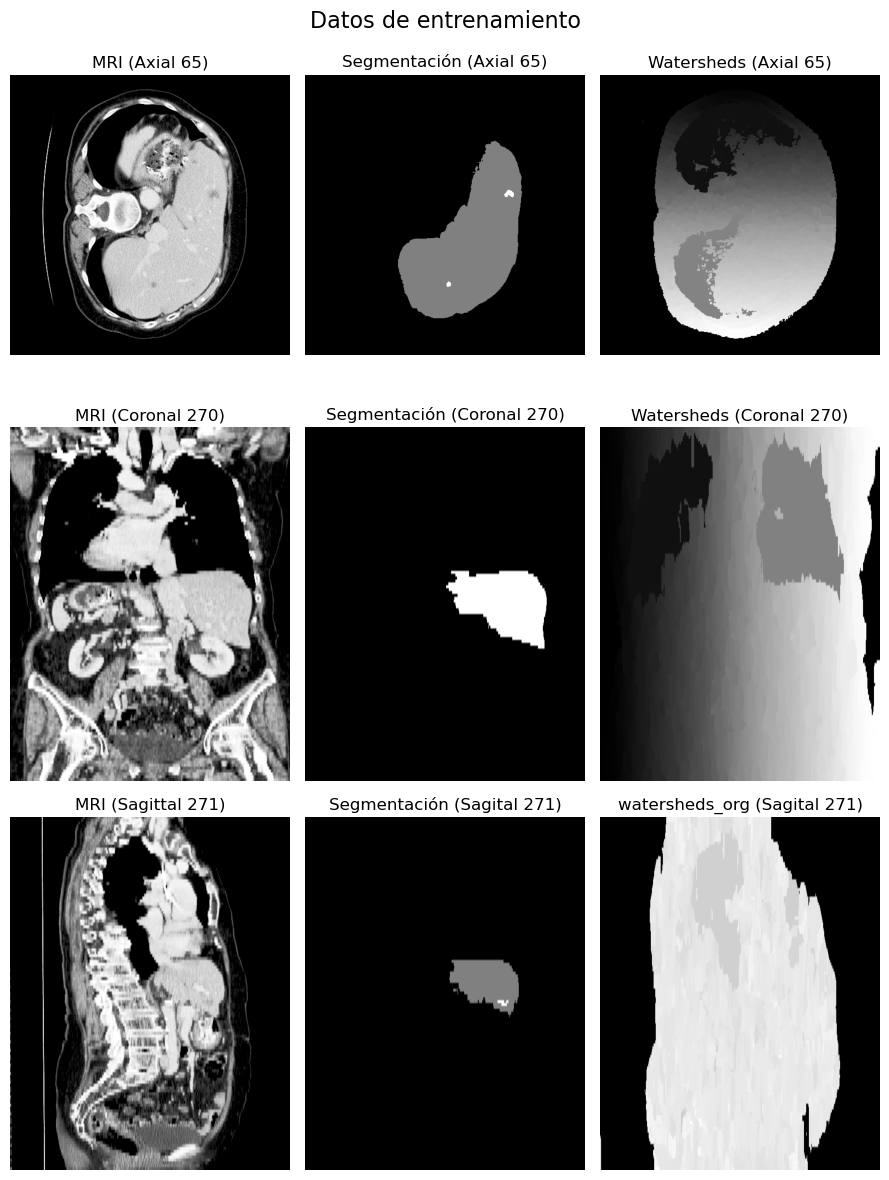

In [6]:
# YOUR CODE HERE
total_segments = len(np.unique(watersheds_org))
print(f"Total number of segments: {total_segments}")

# Visualization of two slices
fig, axes = plt.subplots(3, 3, figsize=(9, 12))

axes[0,0].imshow(vol1[:, :, 65], cmap='gray')
axes[0,0].set_title(f'MRI (Axial 65)')
axes[0,0].axis('off')

axes[0,1].imshow(seg1[:, :, 65], cmap='gray')
axes[0,1].set_title(f'Segmentación (Axial 65)')
axes[0,1].axis('off')

axes[0,2].imshow(watersheds_org[:, :, 65], cmap='gray')
axes[0,2].set_title(f'Watersheds (Axial 65)')
axes[0,2].axis('off')

img_coronal_rotada = np.rot90(vol1[:, 270, :], k=1)
axes[1,0].imshow(img_coronal_rotada, cmap='gray',aspect='auto')
axes[1,0].set_title(f'MRI (Coronal 270)')
axes[1,0].axis('off')

img_coronal_rotada = np.rot90(seg1[:, 270, :], k=1)
axes[1,1].imshow(img_coronal_rotada, cmap='gray',aspect='auto')
axes[1,1].set_title(f'Segmentación (Coronal 270)')
axes[1,1].axis('off')

img_coronal_rotada = np.rot90(watersheds_org[:, 270, :], k=1)
axes[1,2].imshow(img_coronal_rotada, cmap='gray',aspect='auto')
axes[1,2].set_title(f'Watersheds (Coronal 270)')
axes[1,2].axis('off')

img_sagital_rotada = np.rot90(vol1[271, :, :], k=1)
axes[2,0].imshow(img_sagital_rotada, cmap='gray',aspect='auto')
axes[2,0].set_title(f'MRI (Sagittal 271)')
axes[2,0].axis('off')

img_sagital_rotada = np.rot90(seg1[271, :, :], k=1)
axes[2,1].imshow(img_sagital_rotada, cmap='gray',aspect='auto')
axes[2,1].set_title(f'Segmentación (Sagital 271)')
axes[2,1].axis('off')

img_sagital_rotada = np.rot90(watersheds_org[271, :, :], k=1)
axes[2,2].imshow(img_sagital_rotada, cmap='gray',aspect='auto')
axes[2,2].set_title(f'watersheds_org (Sagital 271)')
axes[2,2].axis('off')
fig.suptitle("Datos de entrenamiento",  fontsize=16)
plt.tight_layout()
plt.show()



### 1.2 h-minimos
Ahora, si vemos las estadisticas y la imagen que obtuvimos de la ultima celda de la subseccion anterior nos daremos cuenta que tenemos una sobresegmentación bastante considerable. Esto es debido a que estamos usando los minimos locales en toda la imagen. En esta nueva parte vamos a querer usar lo que son h-minimos, estos como saben nos van a ayudar a disminuir el efecto de la sobresegmentación por lo cual sacaremos los h-minimos con la funcion de ```skimage.morphology``` (https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.h_minima). Sace los h minimos del gradiente morfológico.

In [7]:
minima = ''#Variable que contendrá los h-minimos
# YOUR CODE HERE
minima = h_minima(borders, h=1.0000000000000001)

In [8]:
assert minima.shape == (512,512,123), f'Alteró el tamaño de su volumen de minimos, debe ser (512,512,123) no {minima.shape}'
assert minima.dtype=='uint8' ,f'su volumen debería ser de tipo uint8 no {minima.dtype}'
assert len(np.unique(minima))==2,f'sus minimos solo deberían tener 2 valores, no {len(np.unique(minima))}'

Ahora que ya hicimos el proceso de extracción de los h-minimos, si nos damos cuenta estos siguen teniendo unicamente valores de 1 y 0 por lo cual tendremos que usar la funcion ```label``` de la misma librería que hemos usado hasta el momento.(https://scikit-image.org/docs/stable/api/skimage.morphology.html#label) 

Esta lo que hará será permitirnos que temgamos un valor diferente para cada uno de las semillas, de modo que al entrar en watersheds generen segmentos diferentes

In [9]:
markers = ''# Variable que tendrá los marcadores con sus respectivos labels
watersheds_h = '' #variable que tendrá el resultado de hacer watersheds
# YOUR CODE HERE
markers = label(minima)
watersheds_h = watershed(borders, markers)

In [ ]:
assert markers.shape == (512,512,123), f'Alteró el tamaño de su volumen de minimos, debe ser (512,512,123) no {markers.shape}'
assert markers.dtype=='int64' ,f'su volumen de marcadores debería ser de tipo int64 no {markers.dtype}'
assert watersheds_h.shape == (512,512,123), f'Alteró el tamaño de su volumen de watersheds, debe ser (512,512,123) no {watersheds_h.shape}'
assert watersheds_h.dtype=='int64' ,f'su volumen de watersheds debería ser de tipo int32 no {watersheds_h.dtype}'
assert len(np.unique(markers))-1==len(np.unique(watersheds_h)),f'sus minimos y su resultado de watersheds no tienen los mismos valores {len(np.unique(markers))} y{len(np.unique(watersheds_h))}'

Text(0.5, 0.98, 'Marcadores generados con h_minima')

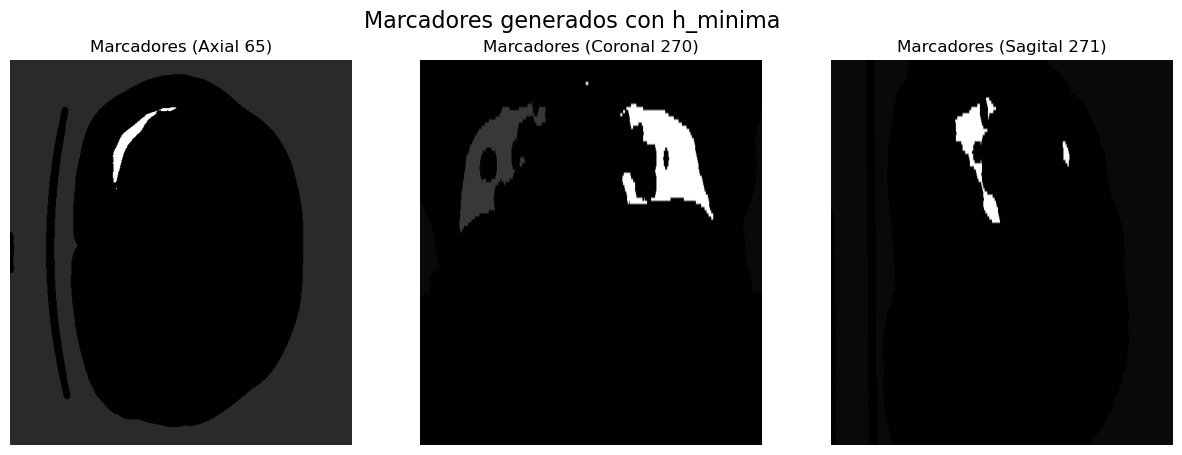

In [10]:
#Como paso extra visualizamos los marcadores que genera el h_minimo 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(markers[:, :, 65], cmap='gray')
axes[0].set_title(f'Marcadores (Axial 65)')
axes[0].axis('off')
axes[0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

jiji= np.rot90(markers[:, 270, :], k=1)
axes[1].imshow(jiji, cmap='gray')
axes[1].set_title(f'Marcadores (Coronal 270)')
axes[1].axis('off')
axes[1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

juju= np.rot90(markers[271, :, :], k=1)
axes[2].imshow(juju, cmap='gray')
axes[2].set_title(f'Marcadores (Sagital 271)')
axes[2].axis('off')
axes[2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión
fig.suptitle("Marcadores generados con h_minima",  fontsize=16)


Otra vez, visualice su volumen en almenos 2 cortes para ver lo que está sucediendo

Total number of segments: 53


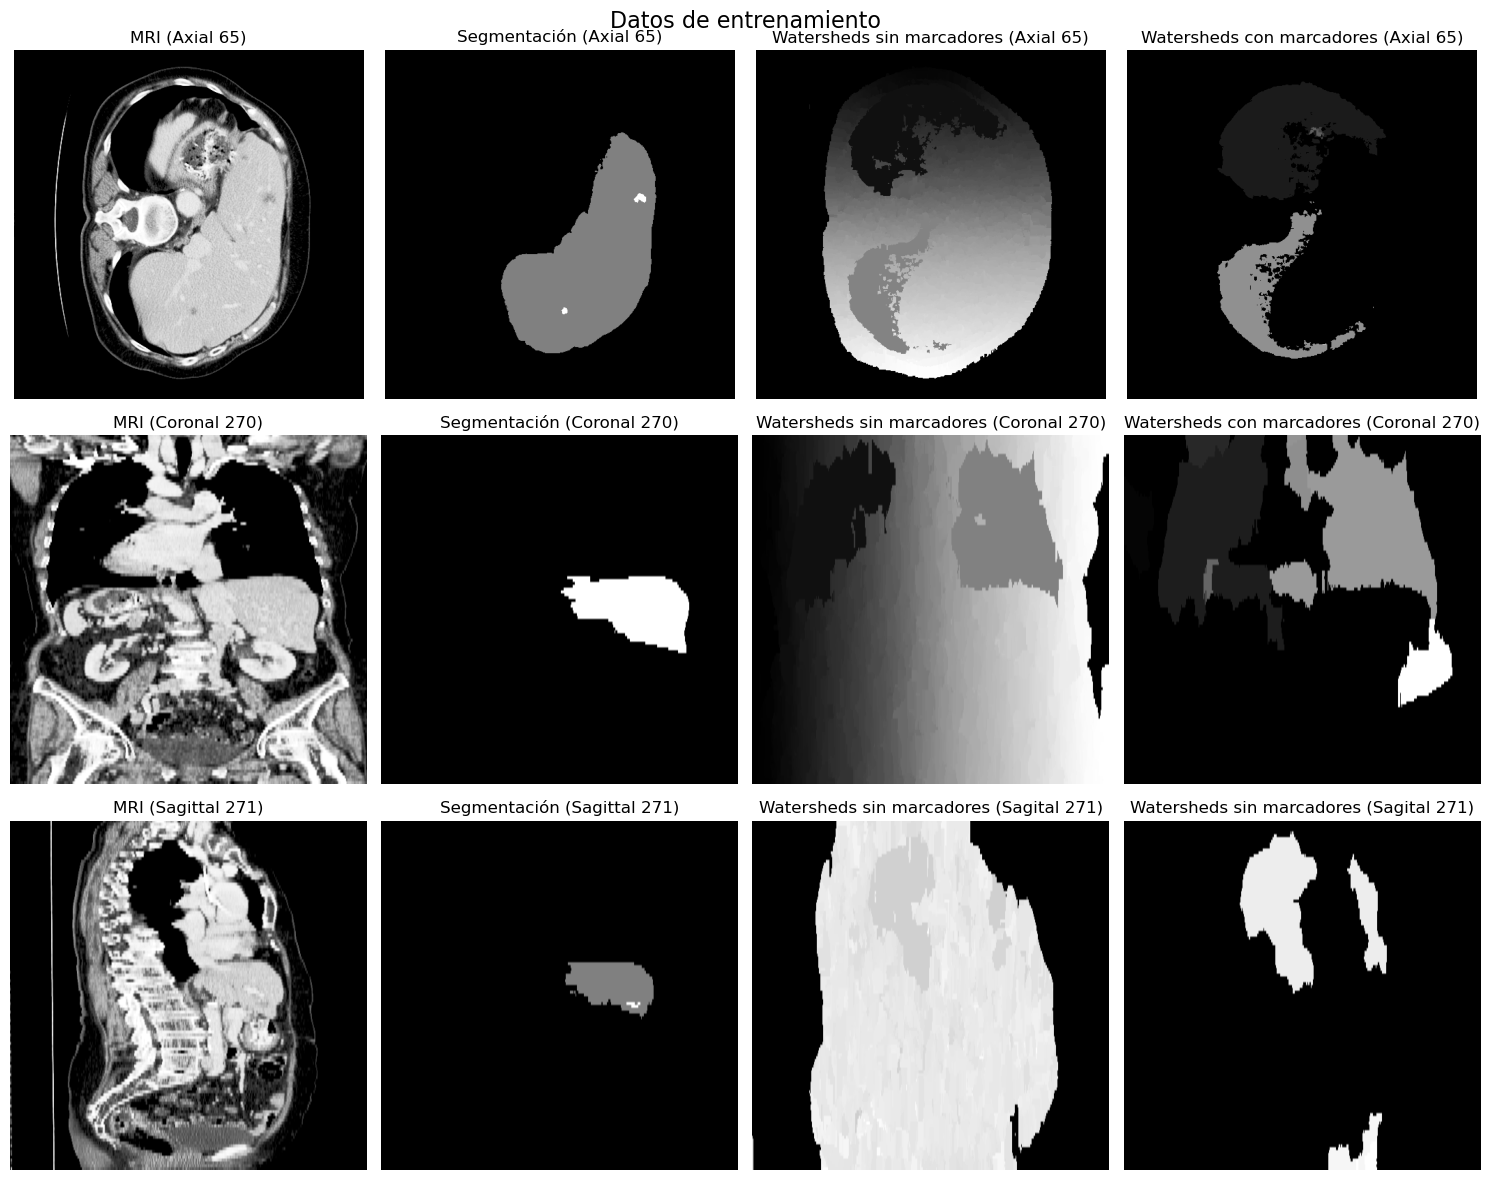

In [11]:
# YOUR CODE HERE
total_segments = len(np.unique(watersheds_h))
print(f"Total number of segments: {total_segments}")

# Visualization of two slices
fig, axes = plt.subplots(3, 4, figsize=(15, 12))

axes[0,0].imshow(vol1[:, :, 65], cmap='gray')
axes[0,0].set_title(f'MRI (Axial 65)')
axes[0,0].axis('off')

axes[0,1].imshow(seg1[:, :, 65], cmap='gray')
axes[0,1].set_title(f'Segmentación (Axial 65)')
axes[0,1].axis('off')

axes[0,2].imshow(watersheds_org[:, :, 65], cmap='gray')
axes[0,2].set_title(f'Watersheds sin marcadores (Axial 65)')
axes[0,2].axis('off')

axes[0,3].imshow(watersheds_h[:, :, 65], cmap='gray')
axes[0,3].set_title(f'Watersheds con marcadores (Axial 65)')
axes[0,3].axis('off')

img_coronal_rotada = np.rot90(vol1[:, 270, :], k=1)
axes[1,0].imshow(img_coronal_rotada, cmap='gray',aspect='auto')
axes[1,0].set_title(f'MRI (Coronal 270)')
axes[1,0].axis('off')

img_coronal_rotada = np.rot90(seg1[:, 270, :], k=1)
axes[1,1].imshow(img_coronal_rotada, cmap='gray',aspect='auto')
axes[1,1].set_title(f'Segmentación (Coronal 270)')
axes[1,1].axis('off')

img_coronal_rotada = np.rot90(watersheds_org[:, 270, :], k=1)
axes[1,2].imshow(img_coronal_rotada, cmap='gray',aspect='auto')
axes[1,2].set_title(f'Watersheds sin marcadores (Coronal 270)')
axes[1,2].axis('off')

img_coronal_rotada = np.rot90(watersheds_h[:, 270, :], k=1)
axes[1,3].imshow(img_coronal_rotada, cmap='gray',aspect='auto')
axes[1,3].set_title(f'Watersheds con marcadores (Coronal 270)')
axes[1,3].axis('off')

img_sagital_rotada = np.rot90(vol1[271, :, :], k=1)
axes[2,0].imshow(img_sagital_rotada, cmap='gray',aspect='auto')
axes[2,0].set_title(f'MRI (Sagittal 271)')
axes[2,0].axis('off')

img_sagital_rotada = np.rot90(seg1[271, :, :], k=1)
axes[2,1].imshow(img_sagital_rotada, cmap='gray',aspect='auto')
axes[2,1].set_title(f'Segmentación (Sagittal 271)')
axes[2,1].axis('off')

img_sagital_rotada = np.rot90(watersheds_org[271, :, :], k=1)
axes[2,2].imshow(img_sagital_rotada, cmap='gray',aspect='auto')
axes[2,2].set_title(f'Watersheds sin marcadores (Sagital 271)')
axes[2,2].axis('off')

img_sagital_rotada = np.rot90(watersheds_h[271, :, :], k=1)
axes[2,3].imshow(img_sagital_rotada, cmap='gray',aspect='auto')
axes[2,3].set_title(f'Watersheds sin marcadores (Sagital 271)')
axes[2,3].axis('off')
fig.suptitle("Datos de entrenamiento",  fontsize=16)

plt.tight_layout()
plt.show()



### 1.3 Marcadores impuestos
Ahora, vimos que h-minimos si bien nos ayuda a que tengan un mejor resultado ya que hay una menor cantidad de segmentos estos siguen siendo mas de los que necesitamos por lo que unicamente queremos dos segmentos. Por esto vamos a realmente hacer un cambio de estos labels.

#### 1.3.1: Clasificación de semillas
Pudimos observar que cada región creada por watersheds tiene una label distinta establecida por la label original de su respectiva semilla. Esto quiere decir que las zonas cuya semilla tiene una misma label, tendrán la misma label una vez realzado watersheds. Usaremos esta idea de clasificar semillas con el fin de crear zonas con mayor robustes de pertenecer al higado. 

Como debemos recordar, las tareas de clasificación supervisada requieren etiquetas para el entrenamiento. En nuestro caso, tenemos labels de cada voxel de los volumenes, y su pertenencia o no al higado. Basicamente tenemos una liste enorme de datos que pertenecen a higado y datos que no. Ahora, requerimos un modelo de clasificación, una forma de determinar que elementos pertenecen y cuales no al higado, una metodología sencilla de determinar esto es el vecino más cercano. 

**Vecino más cercano:** Si contamos con una base de datos amplia y etiquetada, donde sabemos que un dato con determinadas caracteristicas pertenece a una categoria, para saber la pertenencia de un nuevo dato de entrada a una clase especifica solo debemos calcular la distancia de nuestro nuevo dato a todos los datos de entrenamiento. Luego, seleccionamos el dato de menor distancia a nuestro nuevo dato y le asignamos su etiqueta. En este caso, las caracteristicas de los datos son numeros y las distancias que usaremos para comparar será la distancia euclideana:

$D=\sqrt{(a_{1}-b_{1})^{2}+(a_{2}-b_{2})^{2}+...+(a_{n}-b_{n})^{2}}$

Done $a_{1},...,a_{n}$ son las dimensiones del vector de caracteristicas de los datos de entrenamiento y $b_{1},...,b_{n}$ son las dimensiones del vector de caracteristicas del nuevo dato.

**Vector de caracteristicas:** Una forma de representar nuestros datos son mediante un vector, donde cada dimensión corresponde a una caracteristica del dato. Por ejemplo, si tuvieramos que representar a una persona mediante un vector, alguna dimensión puede guardar la información de la edad, la altura, el promedio de carrera, etc. En nuestro caso, nuestros datos son voxeles y las caracteristicas que usaremos para representar nuestros datos serán las intensidades. Sin embargo, usar solo un valor de intensidad para clasificar un voxel es una mala idea. Podemos, en cambio, usar un histograma de intensidades en la vecindad del voxel. 

#### Clases NN_Classifier

Lo primero que vamos a hacer es crear una una clase llamada NN_classifier. Si no tienen conocimiento sobre clases pueden revisar el siguiente [enlace](https://docs.python.org/es/3/tutorial/classes.html) donde podrán encontrar una documentación de las clases en python.
Las clases se componen de 2 elementos principales atributos y métodos. Hay algunos otros términos y elementos pero nos centraremos en los dos más importantes.

Los atributos son variables asociadas a objetos de una clase y son usados para guardas datos asociados a ese objeto. Por otro lado, los métodos son funciones asociadas a un objeto de una clase. Además, hay que tener en cuenta que un objeto es una instancia de una clase, es decir, cuando creamos un arreglo de numpy lo que estamos haciendo es crear un objeto de la clase ndarray de numpy. Por último, hay un método muy importante llamado \_\_init\_\_ que se llama cuando se crea un objeto de la clase. Para clarificar veamos el siguiente ejemplo:

En la siguiente linea podrán observar una clase llamada MyClass. Primero tenemos el método \_\_init\_\_ que se llama cuando se crea el objeto de clase MyClass. A este método le entra como parámetro la variable self que representa la instancia de la clase, es decir, es una forma del objeto de referirse a si mismo. Sin embargo, a ese método también le pueden entrar otros parámetros. Luego, tenemos un atributo que se llama attribute que se crea cuando se inicializa el objeto. Como pueden observar esté atributo también tiene el prefijo self debido a que esta clase pertenece localmente a la instancia de la clase. Por último, tenemos el método method, el cual también posee como parámetro la variable self de modo que puede acceder a otros atributos o métodos de la clase.

In [12]:
class MyClass:
    def __init__(self):
        self.attribute = "This is an attribute"
    
    def method(self):
        print("This is my method.")
        print("Let's print the attribute\n",self.attribute)

Luego de crear la clase, vamos a crear una instancia de la clase, es decir, un objeto. Para eso podemos llamar la Clase anterior de la siguiente manera:

In [13]:
# Dentro del parentesis no ponemos nada, pero si el método __init__ tuvieras
# otros parámetros los tendríamos que poner dentro de este
variable = MyClass()
print(variable)

Así mismo, podemos acceder a los atributos y métodos de un objeto de la siguiente manera:

In [14]:
print(variable.attribute, "\n")
# Nuevamente acá no ponemos nada dentro de los paréntesis, pero si fuera necesario
# se podría
variable.method()

This is an attribute 

This is my method.
Let's print the attribute
 This is an attribute


Ahora que pudimos ver de manera simple como funciona una clase, vamos a crear nuestra propia clase. Para eso debemos tener lo siguiente:

Los atributos de esta clase deben ser los vectores de características y las etiquetas de cada vector de entrenamiento. Los vectores de características y etiquetas deben ser inicializados como arrays vacios.

Los métodos de la clase deben ser fit, predict y euclidean_distance.

>- El método de fit debe recibir las los vectores X y las etiquetas Y como parametro, luego debe guardar los vectores X en el vector de características y las etiquetas Y en el de etiquetas.
>- El método de eclidean_distance debe calcular la distancia euclidea. La idea de este método es que sea utilizado en el método predict. Recuerden que la idea es dividir los problemas en problemas más pequeños.
>- El método predict debe recibir un vector de vectores X, y luego, mediante el metodo de vecino más cercano, determinar la etiqueta de la imagen. Para esto, debe calcular la distancia entre el vector X (que entra como parámetro) con todos los vectores de características, encontrar la menor distancia y extraer la etiqueta de este vector para asignarsela al nuevo dato la etiqueta.

In [15]:
class NNClassifier:
    def _init_(self):
        self.vectores= np.array([]) #atributo del vector de características
        self.etiquetas= np.array([]) #atributo del vector de etiquetas

    def fit(self,X,Y):
        '''
        :param X: Vectores de características
        :param y: Labels de las imagenes
        :return: self (Trained descriptor)
        '''
        # YOUR CODE HERE
        self.vectores = np.array(X)
        self.etiquetas = np.array(Y)
        return self

    def predict(self,X):
        '''
        :param X (array): Imagenes a predecir
        :return: Arreglo de etiquetas predichas
        '''
        # YOUR CODE HERE
        X = np.atleast_2d(X)  # Ensure X is always a 2D array
        predict_vector = []
        for x in X:
            # Calcula la distancia euclídea entre el vector de prueba y todos los vectores de entrenamiento
            distances = np.linalg.norm(self.vectores - x, axis = 1)
            # Encuentra el índice del vector más cercano
            closest_index = np.argmin(distances, axis = 0)
            # Asigna la etiqueta correspondiente al vector más cercano
            predict_vector.append(self.etiquetas[closest_index])

        return np.array(predict_vector)  

In [16]:
train_vector=[[0,0],[0,1],[1,0],[1,1]]
train_labels=[0,0,1,1]
predict=[[0,0.5],[1,0.5],[0.7,0],[0.3,0]]

nn_classifier = NNClassifier()
nn_classifier.fit(train_vector, train_labels)
predict_vector = nn_classifier.predict(predict)

In [17]:
predict_vector

array([0, 1, 1, 0])

In [18]:
assert len(predict_vector)==len(predict)
assert not np.sum(predict_vector-np.array([0,1,1,0])), 'Sus predicciones fueron erroneas'

#### 1.3.2: Datos de entrenamiento
Como dijimos anteriormente, usaremos voxeles de los volumenes de entrenamiento para entrenar nuestro clasificador. Para ello debemos sacar algunas muestras de nuestros datos, no podemos usarlos todos. Les daremos una función que entre por parametro el fold sobre el que sacaremos los voxeles (train, valid o test) junto con la cantidad de bins que usaremos para el histograma de intensidades de la vecindad, usaremos una vecindad de 20x20x20 al rededor del voxel. Esta función retorna una tupla de listas, la primera lista es de datos (el histograma de intensidades) y el segundo es de etiquetas (0 o 1 según la etiqueta dada en el volumen de segmentación).

In [19]:
def voxels_train(fold,bins):
    """Esta función se encarga de extraer los voxels de los volúmenes

    Args:
        fold (str): Fold para escoger volúmenes.
        bins (int): Número de bins en el histograma

    Returns:
        (np.ndarray): Arreglo de histogramas,
        (np.ndarray): Arreglo de etiquetas
    """
    np.random.seed(1)
    
    # Extraer tanto los volúmenes cómo las segmentaciones
    paths_v = glob(os.path.join('DB',fold,'volume*'))
    paths_s = glob(os.path.join('DB',fold,'segmentation*'))
    v=[]
    l=[]
    
    # Recorrer todos los volúmenes
    for i, pv in tqdm(enumerate(paths_v)):
        
        # Abrir volúmenes de entrenamiento y segmentación
        vol = nib.load(pv).get_fdata()
        seg = nib.load(paths_s[i]).get_fdata()>0
        x,y,z=vol.shape
        
        # Este for sirve para extraer los histogramas y etiquetas 100000 voxeles al azar
        for _ in range(100000):
            
            # Elegir la coordenadas 3D al azar
            r1=np.random.randint(10,x-11)
            r2=np.random.randint(10,y-11)
            r3=np.random.randint(10,z-11)
            
            # Obtener la etiqueta
            etiqueta=int(seg[r1,r2,r3])
            
            # Extraer el histograma
            h,_=np.histogram(vol[r1-10:r1+11,r2-10:r2+11,r3-10:r3+11],bins=bins)
            
            # Guardar el histograma y la etiqueta
            v.append(h)
            l.append(etiqueta)
    
    return v, l
            

In [20]:
train_data_total=voxels_train('train',20)

7it [04:07, 35.41s/it]


In [21]:
etiquetas,cuenta=np.unique(train_data_total[1],return_counts=True)
assert np.isclose(np.sum(np.array(train_data_total[1])==1),18233,0.1), f'Debería tener 300 datos positivos en su muestra y tiene {np.sum(np.array(train_data_total[1])==1)}'
assert len(etiquetas)==2, 'Solo deberíamos tener 2 etiquetas en la muestra'
assert np.max(etiquetas)==1 and np.min(etiquetas)==0, 'La maxima etiqueta debe ser 1 y la minima 0'
assert len(train_data_total[0])>3000, f'Su muestra debe tener al menos 3000 datos y tiene {len(train_data_total[0])}'
assert len(train_data_total[0][0])==20, 'Si se hizo un histograma de 20 bins, la dimensión del vector de caracteristicas debe ser 20'

Ahora, clasificar voxeles es una muy mala idea sabiendo la cantidad de datos que contiene un volumen. En cambio lo que haremos será seleccionar un punto adentro y un punto afuera del higado para realizar la segmentación usando watersheds. Los puntos no los buscaremos nostros, sino que usaremos unos voxeles que potencialmente contengan más información, en este caso usaremos los volumenes de h minima creados anteriormente. Adicionalmente, gracias a nuestro conocimiento del organo de interes, vamos a seleccionar unicamente algunas semillas que cumplan ciertas condiciones, esto con el fin de disminuir el peso computacional y aumentar la robustes del modelo. Las semillas que tendremos en cuenta son las que cumplan las siguientes condiciones:

**Para las semillas positivas**

Usaremos una función de segmentación por elemento conexo más grande (diferente a las que usamos en entregas pasadas) y crearemos un volumen de segmentación a priori. Es decir, un volumen segmentado a la primera que puede tener muchos errores pero que ya conocemos que muchos de sus voxeles si pertenecen al higado.

>- Las semillas creadas por h-minima que pertenezcan a su vez al volumen de segmentación a priori.
>- Consideramos positivas las semillas si cumplen las condiciones anteriores y su vecino más cercano en nuestra muestra de entrenamiento tiene una etiqueta de 1.

**Para las semillas negativas**

Debido a la variabilidad de las intensidades de estructuras que no son parte del hígado, solamente tendremos la siguiente condición.

>- Consideramos negativas las semillas si cumplen las condiciones anteriores y su vecino más cercano en nuestra muestra de entrenamiento tiene una etiqueta de 0.

Debemos recordar que nuestro volumen de H minima es un volumen donde todo es 0 menos en los voxeles marcados, que tienen una intensidad de 1. Cree una matriz de 0s del tamaño de la resonancia, recorra su volumen de H minima buscando los voxeles cuya intensidad es 1. 

> Si el voxel i,j,k del **volumen H minima** pertenece a el **volumen de segmentación a priori**, prediga su etiqueta con el clasificador NN, si la etiqueta es 1 entonces cambie la intensidad del voxel i,j,k en la **matriz de 0s** por un **2**.

> Si el pixel i,j,k del **volumen H minima** pertenece a el volumen de segmentación a priori, prediga su etiqueta con el clasificador NN, si la etiqueta es 0 entonces cambie la intensidad del voxel i,j,k en la matriz de 0s por un **1**. 

**Importante:** Dado que estamos realizando una técnica de aprendizaje supervisado "entrenaremos" en los volúmenes de train y evaluaremos en un volumen de validación.

**Nota:** Se le recomienda usar el gradiente morfologico usando una bola de radio 5 para el correcto desarrollo de este punto. Los H minimos se calculan sobre este volumen. Además, es recomendable un h de 0.01.

En la siguiente celda está implementada la función de segmentación con componente conexo más grande en 3D

In [22]:
def vol_max_component(volume, max=None, min=None):
    """Esta función realiza la segmentación mediante elemento conexo más grande en 3D

    Args:
        volume (np.ndarray): Volumen a segmentar
        max (float | None): Limite inferior para realizar la segmentación
        min (float | None): Limite superior para realiza la segmentación

    Return:
        (np.ndarray): Volumen segmentado
    """

    # ASegurarnos que al menos se ingrese un valor de corte
    assert (
        max is not None or min is not None
    ), "Debe ingresar al menos un valor de corte"

    # Si se ingresó un valor de corte máximo realizar la umbralización
    # Sino se mantiene un volumen de unos
    segment_vol_max = np.ones_like(volume)
    if max is not None:
        segment_vol_max = (volume < max).astype(int)

    # Si se ingresó un valor de corte mínimo realizar la umbralización
    # Sino se mantiene un volumen de unos
    segment_vol_min = np.ones_like(volume)
    if min is not None:
        segment_vol_min = (volume > min).astype(int)

    # Hallar la intersección entre los dos elementos
    segment_vol = np.logical_and(segment_vol_max, segment_vol_min)

    # Utilizar la función label para hallar los componentes conexos
    segment_vol = label(segment_vol)

    # Contar la cantidad la cantidad de voxeles que hacen parte del elemento conexo más grande
    unique, unique_counts = np.unique(segment_vol, return_counts=True)

    # Encuentra el índice del elemento conexo más grande sin contar el fondo
    arg = np.argmax(unique_counts[1:])

    # Hallar la etiqueta del elemento conexo más grande
    # La suma de uno se debe a que el fondo tiene la etiqueta 0
    label_max = unique[arg + 1]

    # Finalmente, se saca un volumen binario con solo el componente conexo más grande
    segment_vol = (segment_vol == label_max).astype(int)

    return segment_vol

Para evaluar las segmentaciones utilice la función Jaccard_3D que hemos utilizado desde entregas pasadas.

In [23]:
def Jaccard_3D(Im,Gt):
    '''
    :param Im: Volumen de prediccion.
    :param Gt: Segmentacion groundtruth.
    '''
    # YOUR CODE HERE
    Gt_bin = np.logical_or(Gt == 1, Gt == 2)

    # se usa las funciones logical para generar las interseccion y union
    interseccion = np.logical_and(Im, Gt_bin).sum()
    union = np.logical_or(Im, Gt_bin).sum()

    J = interseccion / (union + 1e-6)
    return J

El jaccard del volúmen resultante de nuestra segmentación con la función de elemento conexo más grande en 3D es: 0.220


(-0.5, 511.5, 511.5, -0.5)

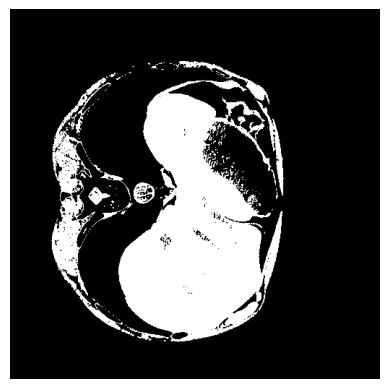

In [24]:
vol_val = nib.load(os.path.join('DB', 'valid', 'volume_34.nii.gz')).get_fdata()
seg_val = (nib.load(os.path.join('DB', 'valid', 'segmentation_34.nii.gz')).get_fdata()>0).astype(np.uint8)

result = vol_max_component(vol_val, 0.95, 0.5)

print(f"El jaccard del volúmen resultante de nuestra segmentación con la función de elemento conexo más grande en 3D es: {Jaccard_3D(result, seg_val):.3f}")
plt.imshow(result[:,:,114], cmap='gray')
plt.axis("off")

In [25]:
print(f"La cantidad de falsos positivos en el volumen segmentado es: {int(np.sum(result - np.logical_and(seg_val, result)))}")
print(f"La cantidad de falsos negativos en el volumen segmentado es: {int(np.sum(seg_val - np.logical_and(seg_val, result)))}")

La cantidad de falsos positivos en el volumen segmentado es: 5140358
La cantidad de falsos negativos en el volumen segmentado es: 6626


Cómo podemos observar el resultado realizar la segmentación con esta función es muy mala. Sin embargo, sabemos que la mayoría de errores son falsos positivos mientras que la cantidad de falsos negativos es mucho menor, por lo que es una buena idea utilizarlo cómo inicio para realizar la clasificación de nuestras semillas.

En la siguiente celda comenzaremos con el proceso creando el volúmen con h mínimos y el volúmen de segmentación a priori.

>- **Consejo:** Para este volumen de segmentación a priori utilice los parámetros 0.95 cómo máximo y 0.5 cómo mínimo.

In [26]:
### Creando el volumen a priori
segmentacion_priori=''#volumen de segmentación a priori
# YOUR CODE HERE

# Se crea la segmentación a priori
segmentacion_priori = vol_max_component(vol_val, 0.95, 0.5)

# Se crea el volumen con h mínimos
element = ball(5)
borders_val = morph_gradient(vol_val,element)
new_minima =  h_minima(borders_val, h=0.001)

Use la siguiente celda para obtener el volumen de semillas clasificadas.

Para realizar el histograma utilice los mismo parámetros que en la función voxels_train.

In [27]:
import numpy as np

h, etiquetas = train_data_total
nn_classifier = NNClassifier()  
nn_classifier.fit(h, etiquetas)

negative = 0
positive = 0

minima2 = np.zeros(new_minima.shape, dtype=np.int32)


# Iterar sobre las dimensiones de h_minima
for i in tqdm(range(new_minima.shape[0]), desc = "Voxels", unit="voxel"):
        for j in range(new_minima.shape[1]):
            for k in range(new_minima.shape[2]):
                if new_minima[i][j][k] == 1 and segmentacion_priori[i,j,k] ==1:
                    # Evitar índices fuera de rango
                    h_predi, _ = np.histogram(vol_val[i-10:i+11, j-10:j+11, k-10:k+11], bins=20, range=(0,1))
                    etiqueta = nn_classifier.predict([h_predi])
                      
                    
                    if etiqueta[0] == 1:
                        minima2[i][j][k] = 2
                        positive += 1
                    elif etiqueta[0]==0:
                        minima2[i][j][k] = 1
                        negative += 1

Voxels: 100%|███████████████████████████████████████████████████████████████████| 512/512 [1:02:46<00:00,  7.36s/voxel]


Visualice sus semillas en el volumen de bordes en ell slice 65. Las semillas son puntos por lo que se puede usar la función [plt.scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) para graficarlos.

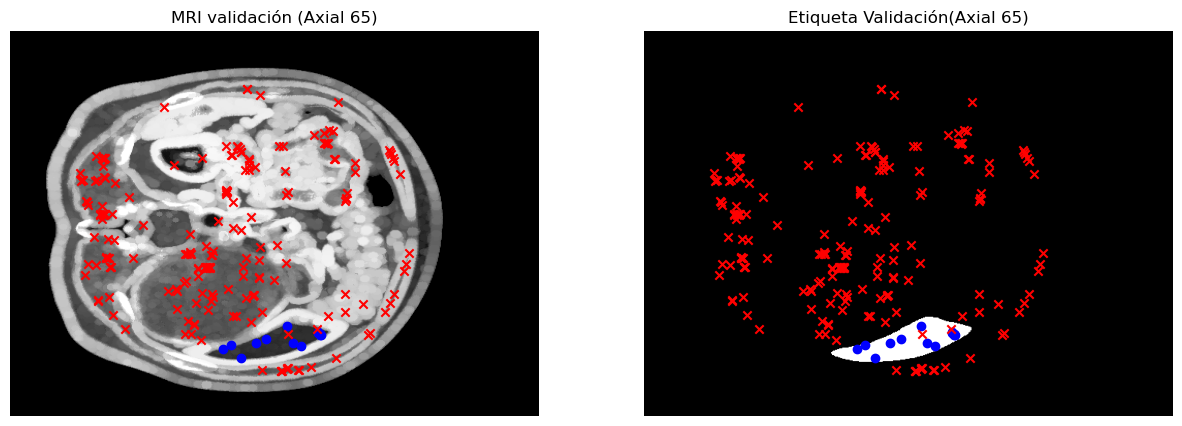

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(borders_val[:, :, 65], cmap='gray')
axes[0].set_title(f'MRI validación (Axial 65)')
axes[0].axis('off')
axes[0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[1].imshow(seg_val[:, :, 65], cmap='gray')
axes[1].set_title(f'Etiqueta Validación(Axial 65)')
axes[1].axis('off')
axes[1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

y_coords, x_coords = np.where(minima2[:, :, 65] == 2)  # Semillas positivas
y_coords_neg, x_coords_neg = np.where(minima2[:, :, 65] == 1)  # Semillas negativas
axes[0].scatter(x_coords, y_coords, color='b', marker='o', label="Semillas positivas")
axes[0].scatter(x_coords_neg, y_coords_neg, color='r', marker='x', label="Semillas negativas")
axes[0].axis('off')
axes[0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[1].scatter(x_coords, y_coords, color='b', marker='o', label="Semillas positivas")
axes[1].scatter(x_coords_neg, y_coords_neg, color='r', marker='x', label="Semillas negativas")
axes[1].axis('off')
axes[1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión


In [29]:
etiquetas, cantidades= np.unique(minima2,return_counts=True)
assert negative and positive, 'Deben haber más de un positivo y un negativo en sus semillas, de no ser así, intente obtener más minimos con h-minimos bajando el h'
assert len(minima2.shape)==3, 'Las dimensiones del volumen de minima2 deberían ser 3'
assert np.sum(minima2[:,:,65]), 'Las semillas deben estar en el slice 65 axial'
assert len(etiquetas)==3, f'Deberían haber 3 etiquetas diferentes en el volumen de etiquetas clasificadas y son {len(etiquetas)}'
assert np.max(etiquetas)==2, f'El valor de la etiqueta maxima debe ser 2 y es {np.max(etiquetas)}'
assert np.min(etiquetas)==0, f'El valor de la etiqueta minima debe ser 0 y es {np.min(etiquetas)}'
assert cantidades[0]>=1 and cantidades[1]>=1 and cantidades[2]>=1, 'Debería haber al menos una etiqueta de cada una en su volumen'

nn_classifier = NNClassifier()
nn_classifier.fit(train_data_total[0], train_data_total[1])

indicesx,indicesy,indicesz=np.where(minima2==2)
h,_=np.histogram(vol_val[indicesx[0]-10:indicesx[0]+11,indicesy[0]-10:indicesy[0]+11,indicesz[0]-10:indicesz[0]+11],bins=20)
result=nn_classifier.predict([h])
assert result[0]==1

indicesx,indicesy,indicesz=np.where(minima2==1)
h,_=np.histogram(vol_val[indicesx[0]-10:indicesx[0]+11,indicesy[0]-10:indicesy[0]+11,indicesz[0]-10:indicesz[0]+11],bins=20)
result=nn_classifier.predict([h])
assert result[0]==0

Ahora, usando estas semillas, cree 1 volumen segmentado usando watersheds. Use como volumen a segmentar el volumen de gradiente morfológico. Sin embargo, esta vez utilice cómo elemento estructurante una bola de radio 1. Luego de segmentar con watersehds, reste 1 a cada etiqueta.

In [30]:
borders='' #Volumen del gradiente morfológico en escala de grises
element = ball(1)
borders = morph_gradient(vol_val,element)


In [31]:
new_segment_vol_gray='' #Volumen segmentado con watersheds usando gradiente grises
new_segment_vol_gray = watershed(borders, minima2)
new_segment_vol_gray -= 1

Evalue sus nuevos volumenes segmentados, visualizelos tambien ¿ve alguna diferencia?

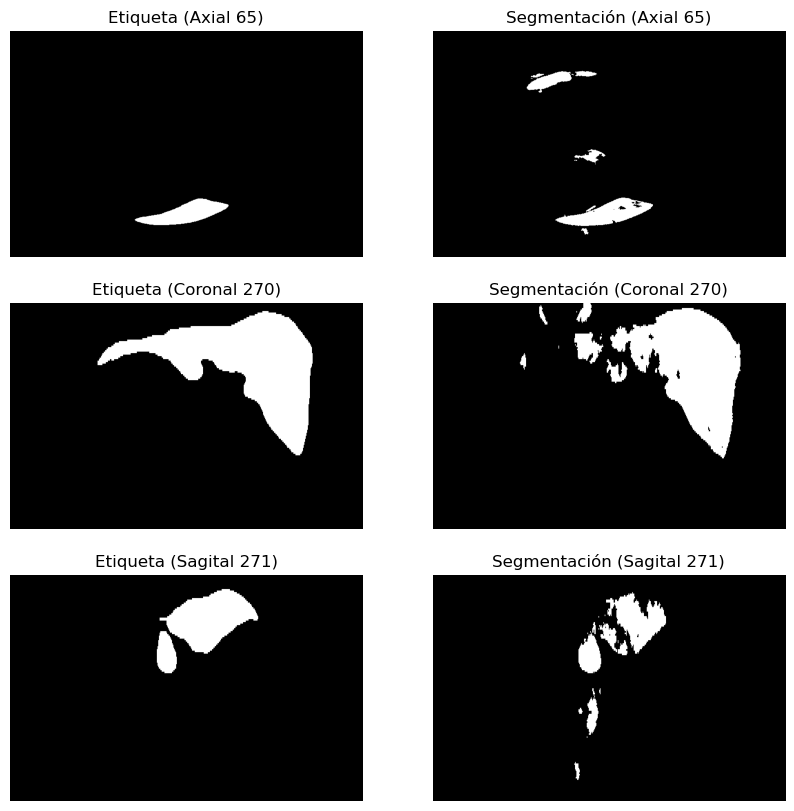

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes[0,0].imshow(seg_val[:, :, 65], cmap='gray')
axes[0,0].set_title(f'Etiqueta (Axial 65)')
axes[0,0].axis('off')
axes[0,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[0,1].imshow(new_segment_vol_gray[:, :, 65], cmap='gray')
axes[0,1].set_title(f'Segmentación (Axial 65)')
axes[0,1].axis('off')
axes[0,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

jiji= np.rot90(seg_val[:, 270, :], k=1)
axes[1,0].imshow(jiji, cmap='gray')
axes[1,0].set_title(f'Etiqueta (Coronal 270)')
axes[1,0].axis('off')
axes[1,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

jiji= np.rot90(new_segment_vol_gray[:, 270, :], k=1)
axes[1,1].imshow(jiji, cmap='gray')
axes[1,1].set_title(f'Segmentación (Coronal 270)')
axes[1,1].axis('off')
axes[1,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

juju= np.rot90(seg_val[271, :, :], k=1)
axes[2,0].imshow(juju, cmap='gray')
axes[2,0].set_title(f'Etiqueta (Sagital 271)')
axes[2,0].axis('off')
axes[2,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

juju= np.rot90(new_segment_vol_gray[271, :, :], k=1)
axes[2,1].imshow(juju, cmap='gray')
axes[2,1].set_title(f'Segmentación (Sagital 271)')
axes[2,1].axis('off')
axes[2,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión


In [33]:
total_segments2 = len(np.unique(new_segment_vol_gray))
print(f"El jaccard del volúmen resultante de nuestra segmentación con la función de elemento conexo más grande en 3D es: {Jaccard_3D(new_segment_vol_gray, seg_val):.3f}")
print(f"Total number of segments: {total_segments2}")


El jaccard del volúmen resultante de nuestra segmentación con la función de elemento conexo más grande en 3D es: 0.618
Total number of segments: 2


In [34]:
assert len(np.unique(new_segment_vol_gray))==2, 'Solo debeían haber 2 etiquetas en su volumen de segmentación'
assert np.max(new_segment_vol_gray)==1, 'El maximo de su volumen de segmentación debería ser 1'
assert np.min(new_segment_vol_gray)==0, 'El minimo de su volumen de segmentación debería ser 0'
assert Jaccard_3D(new_segment_vol_gray,seg_val>0)>0.48, 'Su volumen seguramente fue mal segmentado, puede deberse a la clasificación de sus semillas, intente usar un hminima de 0.01'

Para liberar un poco más de espacio antes de seguir con la siguiente función, borraremos algunas variables.

Para eso utilizaremos globals().items() que tendrá las variables globales definidas. Además, utilizaremos la función sys.getsizeof() para obtener el tamaño del objeto. Finalmente, organizaremos este diccionario para obtener las variables que más gasten memoria.

In [35]:
import sys

def memory_usage():
    memory_dict = {}
    for name, var in globals().items():
        memory_dict[name] = sys.getsizeof(var)
    
    return memory_dict
    
memory_dict = memory_usage()
memory_list = sorted(memory_dict.items(), key=lambda item:item[1], reverse=True)

for element in memory_list[:8]:
    print(f"Variable: {element[0]:30} Tamaño: {element[1] / (1024 ** 2)} MB")

# Si hay alguna variable que no vayas a utilizar puedes utilizar del para eliminarla de la siguiente manera
# vol_prueba_liberacion = vol1
# del vol_prueba_liberacion

Variable: borders                        Tamaño: 302.00013732910156 MB
Variable: borders_val                    Tamaño: 302.00013732910156 MB
Variable: seg1                           Tamaño: 246.00013732910156 MB
Variable: markers                        Tamaño: 246.00013732910156 MB
Variable: segmentacion_priori            Tamaño: 151.00013732910156 MB
Variable: minima2                        Tamaño: 151.00013732910156 MB
Variable: new_segment_vol_gray           Tamaño: 151.00013732910156 MB
Variable: watersheds_org                 Tamaño: 123.00013732910156 MB


In [36]:
#vol_prueba_liberacion = seg_val
del new_segment_vol_gray                       

**Muy importante no borres variables que no conozcas, por ejemplo, variables que comiencen o termine por _ pueden ser variables del entorno de ejecución.**

## Validación
Ya hemos creado nuestra función de predicción y hemos verificado su funcionamiento en entrenamiento, es momento de la experimentación. Debe realizar los experimentos y evaluarlos en **Validación**. Puede usar lo que aprendió de pre-procesamiento, post-procesamiento y el algoritmo de segmentación de su preferencia (clasificación de semillas, umbralización con Vol2D_max_component o con vol_max_component) Pero debe recordar la experimentación exhaustiva. Ya hemos experimentado con pre y post procesamiento en la entrega  pasada, por lo que se le recomienda establecer un procedimiento estandar para estos pasos (no requiere experimentar nuevamente con ello).

Debe realizar al menos 4 experimentos con cualquiera de los algoritmos y debe justificar cada experimento en el informe. Calificaré de igual forma su creatividad y sus resultados, no tengan miedo de probar cosas.

Cree una función que entre como parametro un volumen y retorne su segmentación con el algoritmo final.

In [37]:
#Funciones de pre y post procesamiento 

from skimage.morphology import remove_small_objects
from scipy.ndimage import binary_fill_holes

def max_component(Im,umbral,operador):
    'Im (ndarray): Imagen a segmentar'
    'umbral (float): Umbral a utilizar'
    'operador (str): Puede ser "mayor" para > o "menor" para < segun se quiera umbralizar'
    # YOUR CODE HERE
    if operador == "mayor":
        binary_mask = Im > umbral
    elif operador == "menor":
        binary_mask = Im < umbral
    else:
        return("Operador debe ser 'mayor' o 'menor'")

    # Se usa la funcion labe de skimage.measure.label para darle un label/descripcion a cada componente conexo
    labeled_mask = label(binary_mask)
    # Se remueve el fondo o label==0
    unique_labels = np.unique(labeled_mask)
    unique_labels = unique_labels[unique_labels != 0]
    if len(unique_labels) == 0:
        return np.zeros_like(Im, dtype=bool)  #
    # Se busca el componente conexo mas grande, despues de eliminar el fondo
    max_label = max(unique_labels, key=lambda label: np.sum(labeled_mask == label))
    # Crear una mascara del componente conexo mas grande
    max_comp = labeled_mask == max_label
    return max_comp

def Vol2D_max_component(Vol,umbral,operador):
    'Vol (ndarray): Imagen a segmentar'
    'umbral (float): Umbral a utilizar'
    'operador (str): Puede ser "mayor" para > o "menor" para < segun se quiera umbralizar'
    #Se crea una imagen de 0 del tamaño del volumen
    segmentacion=np.zeros(Vol.shape)
    #Se hace un recorrido por cada slice del volumen y se le añade a segmentación
    for i in range(Vol.shape[2]):
        slice_segmentada=max_component(Vol[:,:,i],umbral,operador)
        segmentacion[:,:,i]=slice_segmentada

    return segmentacion

def geodesic_dilatation(mask, E1, E2, max_iterations):
    result= erosion(mask,E1)#mask.copy()
    iterations = 0
    while iterations < max_iterations:
        dilated = dilation(result, E2)
        new_resul = np.logical_and(mask, dilated)
        if np.array_equal(new_resul, result):
            break
        result = new_resul
        iterations +=1

    return result, iterations

def custom_liver_3d(radius_x, radius_y, radius_z):
    size_x = 2 * radius_x + 1
    size_y = 2 * radius_y + 1
    size_z = 2 * radius_z + 1
    center_x, center_y, center_z = radius_x, radius_y, radius_z
    selem = np.zeros((size_x, size_y, size_z), dtype=np.uint8)
    for x in range(size_x):
        for y in range(size_y):
            for z in range(size_z):
                distance = np.sqrt(
                    ((x - center_x) / radius_x) ** 2 +
                    ((y - center_y) / radius_y) ** 2 +
                    ((z - center_z) / radius_z) ** 2
                )
                if distance <= 1:
                    selem[x, y, z] = 1
    return selem

selem = custom_liver_3d(7,5,5)

from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.morphology import ball
from skimage.segmentation import watershed

def hybrid_watershed_segmentation(vol_val):

    threshold = threshold_otsu(vol_val)
    binary_mask = vol_val > threshold

    labeled_mask = label(binary_mask)
    regions = regionprops(labeled_mask)
    if len(regions) == 0:
        raise ValueError("No encontrado!")
    largest_region = max(regions, key=lambda r: r.area)
    refined_seed = labeled_mask == largest_region.label

    morph_gradient_volume = morph_gradient(vol_val,ball(1))

    segmented_volume = watershed(morph_gradient_volume, minima2)
    
    segmented_volume = segmented_volume -1
    
    return segmented_volume


In [38]:
def pre_procesamiento(vol):
    voli = vol.copy()
    # Realizamos apertura
    voli = erosion(voli,selem)
    voli = dilation(voli,selem)
    vol_pre = vol - voli
    #Creamos la máscara
    mask = (vol_pre >= 0.2) & (vol_pre <= 1)
    vol_pre_total =np.copy(vol)
    vol_pre_total[mask] -= vol_pre[mask]
    # Modificamos el volumen de procesamiento directamente
    
    return vol_pre_total

In [39]:
from scipy.ndimage import binary_fill_holes
def post_procesamiento(vol):
    voli = vol.copy()
    # Realizamos apertura
    voli = dilation(voli,selem)
    voli = erosion(voli,selem)
    filled_vol = binary_fill_holes(voli)

    return filled_vol

In [40]:
vol_val = nib.load(os.path.join('DB', 'valid', 'volume_34.nii.gz')).get_fdata()
seg_val = (nib.load(os.path.join('DB', 'valid', 'segmentation_34.nii.gz')).get_fdata()>0).astype(np.uint8)

In [41]:
# Realizando preprocesamiento
pre_ = pre_procesamiento(vol_val)

In [42]:
# Utilizando el algoritmo de vol_max_component
max_component_ = vol_max_component(pre_, 0.95, 0.5)

In [43]:
# Utilizando el algoritmo de Vol2D_max_component
max_2D = Vol2D_max_component(pre_, 0.8, "mayor")

In [44]:
waterhibrido = hybrid_watershed_segmentation(pre_)

In [45]:
# Utilizando el algoritmo de clasificación de semillas
water_semi = watershed(borders, minima2)
water_semi = water_semi - 1   

In [49]:
# Realizando postprocesamiento
post_max_component = post_procesamiento(max_component_)
post_max_2D = post_procesamiento(max_2D)
post_water_semi = post_procesamiento(water_semi)
post_hibrido = post_procesamiento(waterhibrido)

In [50]:
#Cálculamos qué jaccard antes del posprocesamiento
Jmax_component = Jaccard_3D(max_component_,seg_val)
Jmax_2D = Jaccard_3D(max_2D,seg_val)
Jwater_semi = Jaccard_3D(water_semi, seg_val)
Jhibrido = Jaccard_3D(waterhibrido,seg_val)

print(f"Jaccard con vol_max_component: {Jmax_component}")
print(f"Jaccard con Vol2D_max_component: {Jmax_2D}")
print(f"Jaccard con clasificación de semillas: {Jwater_semi}")
print(f"Jaccard con watershed y otsu: {Jmax_component}")


Jaccard con vol_max_component: 0.36177448564103676
Jaccard con Vol2D_max_component: 0.6615233599087302
Jaccard con clasificación de semillas: 0.6178973249069721
Jaccard con watershed y otsu: 0.36177448564103676


In [51]:
#Cálculamos qué jaccard después del posprocesamiento
Jmax_component_ = Jaccard_3D(post_max_component,seg_val)
Jmax_2D_ = Jaccard_3D(post_max_2D,seg_val)
Jwater_semi_ = Jaccard_3D(post_water_semi, seg_val)

print(f"Jaccard con vol_max_component: {Jmax_component_}")
print(f"Jaccard con Vol2D_max_component: {Jmax_2D_}")
print(f"Jaccard con clasificación de semillas: {Jwater_semi_}")
print(f"Jaccard con watershed y otsu: {Jmax_component}")


Jaccard con vol_max_component: 0.21959099534795135
Jaccard con Vol2D_max_component: 0.6910810700289961
Jaccard con clasificación de semillas: 0.6409329248915052
Jaccard con watershed y otsu: 0.36177448564103676


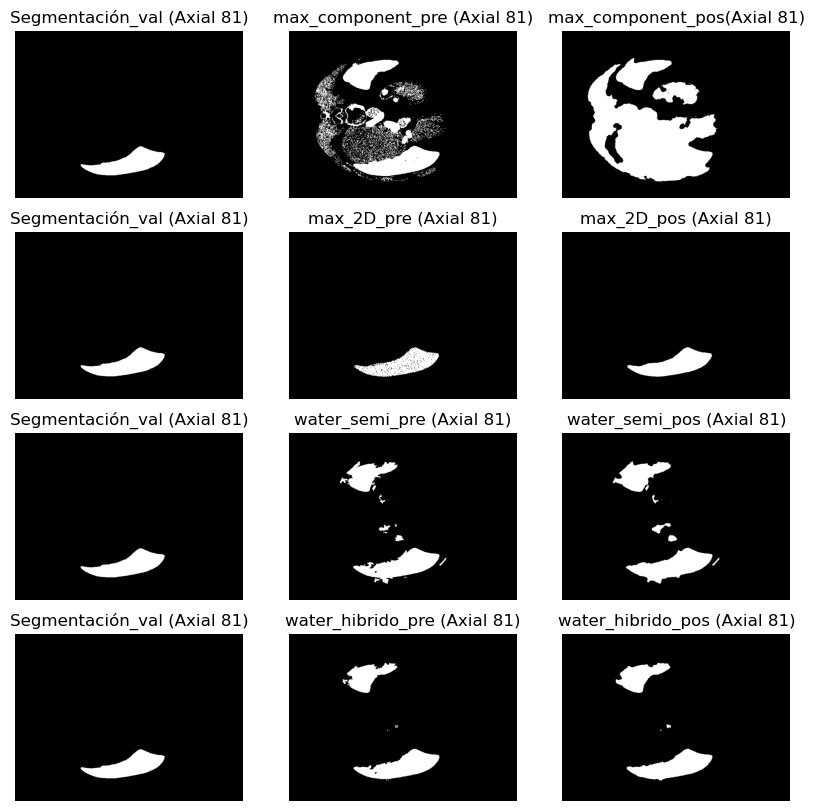

In [66]:
fig, axes = plt.subplots(4, 3, figsize=(10, 10))

axes[0,0].imshow(seg_val[:, :, 81], cmap='gray')
axes[0,0].set_title(f'Segmentación_val (Axial 81)')
axes[0,0].axis('off')
axes[0,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[0,1].imshow(max_component_[:, :, 81], cmap='gray')
axes[0,1].set_title(f'max_component_pre (Axial 81)')
axes[0,1].axis('off')
axes[0,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[0,2].imshow(post_max_component[:, :, 81], cmap='gray')
axes[0,2].set_title(f'max_component_pos(Axial 81)')
axes[0,2].axis('off')
axes[0,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[1,0].imshow(seg_val[:, :, 81], cmap='gray')
axes[1,0].set_title(f'Segmentación_val (Axial 81)')
axes[1,0].axis('off')
axes[1,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[1,1].imshow(max_2D[:, :, 81], cmap='gray')
axes[1,1].set_title(f'max_2D_pre (Axial 81)')
axes[1,1].axis('off')
axes[1,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[1,2].imshow(post_max_2D[:, :, 81], cmap='gray')
axes[1,2].set_title(f'max_2D_pos (Axial 81)')
axes[1,2].axis('off')
axes[1,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[2,0].imshow(seg_val[:, :, 81], cmap='gray')
axes[2,0].set_title(f'Segmentación_val (Axial 81)')
axes[2,0].axis('off')
axes[2,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[2,1].imshow(water_semi[:, :, 81], cmap='gray')
axes[2,1].set_title(f'water_semi_pre (Axial 81)')
axes[2,1].axis('off')
axes[2,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[2,2].imshow(post_water_semi[:, :, 81], cmap='gray')
axes[2,2].set_title(f'water_semi_pos (Axial 81)')
axes[2,2].axis('off')
axes[2,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[3,0].imshow(seg_val[:, :, 81], cmap='gray')
axes[3,0].set_title(f'Segmentación_val (Axial 81)')
axes[3,0].axis('off')
axes[3,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[3,1].imshow(waterhibrido[:, :, 81], cmap='gray')
axes[3,1].set_title(f'water_hibrido_pre (Axial 81)')
axes[3,1].axis('off')
axes[3,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[3,2].imshow(post_hibrido[:, :, 81], cmap='gray')
axes[3,2].set_title(f'water_hibrido_pos (Axial 81)')
axes[3,2].axis('off')
axes[3,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

Debido a que se evidencia que con el algoritmo de segmentación de "Vol2D_max_component" se obtienen mejores resultados antes del preprocesamiento y luego del postprocesamiento se propone realizar realizar la segmentación con este metodo.

In [54]:
post_mejor_max_2D = post_procesamiento(max_2D)

In [55]:
Jmax_2D_mejorado = Jaccard_3D(post_mejor_max_2D,seg_val)
print(Jmax_2D_mejorado)

0.6910810700289961


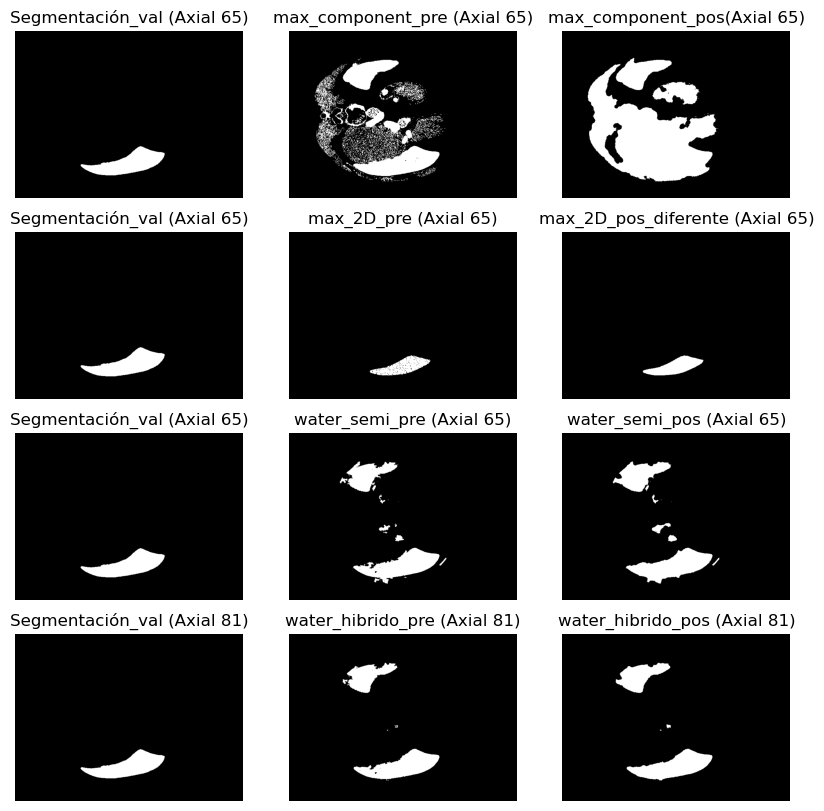

In [67]:
fig, axes = plt.subplots(4, 3, figsize=(10, 10))

axes[0,0].imshow(seg_val[:, :, 81], cmap='gray')
axes[0,0].set_title(f'Segmentación_val (Axial 65)')
axes[0,0].axis('off')
axes[0,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[0,1].imshow(max_component_[:, :, 81], cmap='gray')
axes[0,1].set_title(f'max_component_pre (Axial 65)')
axes[0,1].axis('off')
axes[0,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[0,2].imshow(post_max_component[:, :, 81], cmap='gray')
axes[0,2].set_title(f'max_component_pos(Axial 65)')
axes[0,2].axis('off')
axes[0,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[1,0].imshow(seg_val[:, :, 81], cmap='gray')
axes[1,0].set_title(f'Segmentación_val (Axial 65)')
axes[1,0].axis('off')
axes[1,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[1,1].imshow(max_2D[:, :, 65], cmap='gray')
axes[1,1].set_title(f'max_2D_pre (Axial 65)')
axes[1,1].axis('off')
axes[1,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[1,2].imshow(post_mejor_max_2D[:, :, 65], cmap='gray')
axes[1,2].set_title(f'max_2D_pos_diferente (Axial 65)')
axes[1,2].axis('off')
axes[1,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[2,0].imshow(seg_val[:, :, 81], cmap='gray')
axes[2,0].set_title(f'Segmentación_val (Axial 65)')
axes[2,0].axis('off')
axes[2,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[2,1].imshow(water_semi[:, :, 81], cmap='gray')
axes[2,1].set_title(f'water_semi_pre (Axial 65)')
axes[2,1].axis('off')
axes[2,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[2,2].imshow(post_water_semi[:, :, 81], cmap='gray')
axes[2,2].set_title(f'water_semi_pos (Axial 65)')
axes[2,2].axis('off')
axes[2,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[3,0].imshow(seg_val[:, :, 81], cmap='gray')
axes[3,0].set_title(f'Segmentación_val (Axial 81)')
axes[3,0].axis('off')
axes[3,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[3,1].imshow(waterhibrido[:, :, 81], cmap='gray')
axes[3,1].set_title(f'water_hibrido_pre (Axial 81)')
axes[3,1].axis('off')
axes[3,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[3,2].imshow(post_hibrido[:, :, 81], cmap='gray')
axes[3,2].set_title(f'water_hibrido_pos (Axial 81)')
axes[3,2].axis('off')
axes[3,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

In [57]:
def Segmentacion(vol):
    # Realizamos preprocesamiento
    pre_ = pre_procesamiento(vol)

    # Utilizando el algoritmo de Vol2D_max_component
    max_2D = Vol2D_max_component(pre_, 0.8, "mayor")
    
    # Realizamos posprocesamiento
    post_mejor_max_2D = post_procesamiento(max_2D)
        
    return post_mejor_max_2D

In [58]:
mean_jaccard = 0.0
vol_val_paths = glob(os.path.join('DB','valid','volume_*.nii.gz'))
seg_val_paths = glob(os.path.join('DB','valid','segmentation_*.nii.gz'))
pbar = tqdm(total=len(vol_val_paths))
for i, (vol_val_path, seg_val_path) in enumerate(zip(vol_val_paths, seg_val_paths), start = 1):
    vol_val = nib.load(vol_val_path).get_fdata()
    seg_val = nib.load(seg_val_path).get_fdata()
    seg_total = Segmentacion(vol_val)
    jaccard_val = Jaccard_3D(seg_total,seg_val)
    mean_jaccard += (jaccard_val - mean_jaccard) / i
    pbar.update(1)
pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [09:32<00:00, 190.77s/it]


In [59]:
print(mean_jaccard)

0.5540092206366471


In [60]:
assert len(np.unique(seg_total))==2, 'Solo deberían haber 2 etiquetas en su volumen'
assert np.max(seg_total)==1, 'El maximo de su segmentación debería ser 1'
assert mean_jaccard>0.50, 'Su experimentación debería superar el 0.50 de Jaccard, el baseline'

In [61]:
print(mean_jaccard)

0.5540092206366471


## Prueba
Ahora es momento de hacer la prueba, ya hicimos todo este proceso en el conjunto de validación por lo que ya conseguimos nuestra mejor metodología. Ahora lo que nos queda es correr este algoritmo en el volumen de prueba y así poder observar el desempeño final de nuestro algoritmo.
Además hagan un subplot con almenos 4 cortes axiales donde se pueda apreciar la calidad de la segmentación.

In [62]:
mean_jaccard = 0.0
vol_test_paths = glob(os.path.join('DB','test','volume_*.nii.gz'))
seg_test_paths = glob(os.path.join('DB','test','segmentation_*.nii.gz'))
pbar = tqdm(total=len(vol_test_paths))
for i, (vol_test_path, seg_test_path) in enumerate(zip(vol_test_paths, seg_test_paths), start=1):
    vol_test = nib.load(vol_test_path).get_fdata()
    seg_test = nib.load(seg_test_path).get_fdata()
    seg_total = Segmentacion(vol_test)
    jaccard_test = Jaccard_3D(seg_total,seg_test)
    mean_jaccard += (jaccard_test - mean_jaccard) / i
    pbar.update(1)
pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [12:13<00:00, 244.34s/it]


In [63]:
assert mean_jaccard>0.48, 'Su algoritmo final debería superar el baseline'

In [64]:
print(mean_jaccard)

0.4844249562996356


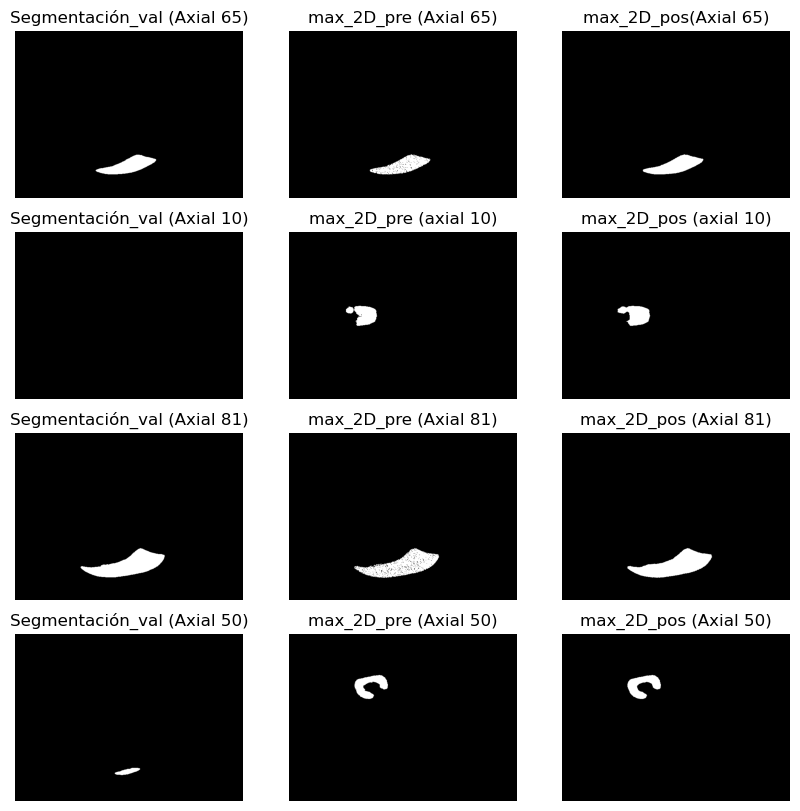

In [65]:
vol_val = nib.load(os.path.join('DB', 'valid', 'volume_34.nii.gz')).get_fdata()
seg_val = (nib.load(os.path.join('DB', 'valid', 'segmentation_34.nii.gz')).get_fdata()>0).astype(np.uint8)
fig, axes = plt.subplots(4, 3, figsize=(10, 10))

axes[0,0].imshow(seg_val[:, :, 65], cmap='gray')
axes[0,0].set_title(f'Segmentación_val (Axial 65)')
axes[0,0].axis('off')
axes[0,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[0,1].imshow(max_2D[:, :, 65], cmap='gray')
axes[0,1].set_title(f'max_2D_pre (Axial 65)')
axes[0,1].axis('off')
axes[0,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[0,2].imshow(post_mejor_max_2D[:, :, 65], cmap='gray')
axes[0,2].set_title(f'max_2D_pos(Axial 65)')
axes[0,2].axis('off')
axes[0,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[1,0].imshow(seg_val[:, :, 10], cmap='gray')
axes[1,0].set_title(f'Segmentación_val (Axial 10)')
axes[1,0].axis('off')
axes[1,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[1,1].imshow(max_2D[:, :, 10], cmap='gray')
axes[1,1].set_title(f'max_2D_pre (axial 10)')
axes[1,1].axis('off')
axes[1,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[1,2].imshow(post_mejor_max_2D[:, :, 10], cmap='gray')
axes[1,2].set_title(f'max_2D_pos (axial 10)')
axes[1,2].axis('off')
axes[1,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión


axes[2,0].imshow(seg_val[:, :, 81], cmap='gray')
axes[2,0].set_title(f'Segmentación_val (Axial 81)')
axes[2,0].axis('off')
axes[2,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[2,1].imshow(max_2D[:, :, 81], cmap='gray')
axes[2,1].set_title(f'max_2D_pre (Axial 81)')
axes[2,1].axis('off')
axes[2,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[2,2].imshow(post_mejor_max_2D[:, :, 81], cmap='gray')
axes[2,2].set_title(f'max_2D_pos (Axial 81)')
axes[2,2].axis('off')
axes[2,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[3,0].imshow(seg_val[:, :, 50], cmap='gray')
axes[3,0].set_title(f'Segmentación_val (Axial 50)')
axes[3,0].axis('off')
axes[3,0].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[3,1].imshow(max_2D[:, :, 50], cmap='gray')
axes[3,1].set_title(f'max_2D_pre (Axial 50)')
axes[3,1].axis('off')
axes[3,1].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

axes[3,2].imshow(post_mejor_max_2D[:, :, 50], cmap='gray')
axes[3,2].set_title(f'max_2D_pos (Axial 50)')
axes[3,2].axis('off')
axes[3,2].set_aspect('auto')  # Ajustar el aspecto para evitar distorsión

## Entregables
Los entregables para esta entrega son un Jupyter notebook (.ipynb), un informe (.pdf) y un archivo de texto (.txt).

El Jupyter notebook debe estar completamente resuelto. Recuerde que la nota depende del funcionamiento de su código. El archivo de texto corresponde a las secciones de código de su Jupyter notebook, para más información sobre cómo convertir las secciones de código del Jupyter notebook a archivo de texto ver el video en el siguiente [enlace](https://uniandes-edu-co.zoom.us/rec/share/QOxUUIw7Uz9DsnKPyftOXZgM4bx5d7KHMYK-dqvGnkyJ2GfqvT7NU3lhQc0NtNSU.jveWB2H34S4uLIoB).

En este miniproyecto debe hacer un informe con Introducción, Resultados y análisis, y Conclusiones respondiendo las preguntas en las secciones donde usted crea pertinente responderlas. Toda la información sobre secciones, preguntas y elementos adicionales está en la siguiente sección de informe. La extensión máxima del informe es de 5 páginas. El informe debe utilizar el formato que puede encontrar siguiente [enlace](https://github.com/cvpr-org/author-kit). Si tiene dudas de cómo utilizar el formato puede preguntar al Asistente Graduado.

## Informe
Ya hemos realizado todos los procedimientos para mejorar los resultados finales de nuestro modelo. Recuerde que queremos observar la sensibilidad de nuestro modelo a los diferentes parametros que hemos probado para así obtener el mejor proceso posible y habrán ocasiones en las que combinaciones de parametros funcionarán mejor que los parametros individuales, tengalo en cuenta. 

No olvide contestar las siguientes preguntas en su informe:

### Parte 1: watersheds
- ¿Que puede notar en su implementación original de watersheds? ¿Cuantos segmentos hay?
- Proponga otra forma de conseguir etiquetas para los segmentos o las semillas.
- La metodología de la clasificación de semillas ¿Que caracteristicas del objeto utiliza para segmentarlo, forma, textura, intensidad, entre otros? Justifique su respuesta
- En cuanto el uso de la segmentación a priori ¿Es preferible una alta cobertura o una alta precisión en este caso en particular?
- ¿Qué limitaciones tiene el método de clasificación de semillas?

### ¡Validación y Prueba!
- Incluyan los resultados del indice de Jaccard, incluyendo el subplot.
- Realice una descripción de su método final y justifique porque lo hizo de esa manera, se calificará la creatividad de su método. *Nota* Si no realiza la descripción tendrá una penalización tanto en el informe como en el código.
- ¿Fueron congruentes sus resultados en prueba con los hechos en validación? Si no es así, entonces ¿Por qué cree que su metodo funciona bien en entrenamiento y mal en validación y test? Observe los volumenes de validación y test si es necesario para contestar.
- ¿Que problemas pueden ver en sus resultados cualitativos?
- ¿Como mejorarían su metodo?

In [ ]:
from utils import *
converter("Entrega 3")